## Import data

In [87]:
import pandas as pd
df = pd.read_csv('Data/new_1.csv', index_col=0, low_memory=False)
df.head()

,NEIGHBORHOOD_nycod,BLOCK_nycod,LOT_nycod,ADDRESS_nycod,APARTMENT NUMBER_nycod,ZIP CODE_nycod,units_res_nycod,units_comm_nycod,units_tot_nycod,sqft_land_nycod,...,appbbl_pluto,appdate_pluto,plutomapid_pluto,firm07_flag_pluto,pfirm15_flag_pluto,version_pluto,dcpedited_pluto,latitude_pluto,longitude_pluto,notes_pluto
0,ALPHABET CITY,375,28,738 EAST 6TH STREET,,10009,11.0,0.0,11.0,1750.0,...,NaN,NaN,1.0,NaN,NaN,22v3.1,NaN,40.722732,-73.977946,NaN
1,ALPHABET CITY,385,36,27 AVENUE C,,10009,24.0,1.0,25.0,2650.0,...,NaN,NaN,1.0,NaN,NaN,22v3.1,NaN,40.721552,-73.981031,NaN
2,ALPHABET CITY,392,5,151 AVENUE B,,10009,5.0,0.0,5.0,2139.0,...,NaN,NaN,1.0,NaN,1.0,22v3.1,t,40.726498,-73.979864,NaN
3,ALPHABET CITY,392,6,153 AVENUE B,,10009,5.0,0.0,5.0,1633.0,...,NaN,NaN,1.0,NaN,1.0,22v3.1,NaN,40.726569,-73.979857,NaN
4,ALPHABET CITY,400,61,193 EAST 4TH STREET,,10009,11.0,1.0,12.0,2388.0,...,NaN,NaN,1.0,NaN,NaN,22v3.1,NaN,40.724240,-73.984223,NaN


# Clean data

## Drop columns

In [88]:
#drop empty
df = df.dropna(how='all', axis=1)
df = df.dropna(how='all', axis=0)

#lowercase, sort alphabetically, find duplicates
df.columns = map(str.lower, df.columns)
df.columns = [i.replace('\n', " ").replace("  ", " ").replace(" ","") for i in df.columns]
not_unique = []
for i in list(df.columns):
    if list(df.columns).count(i) != 1:
        not_unique.append(i)
df = df.drop(columns=not_unique, axis=1)
df = df.reindex(sorted(df.columns), axis=1)

#drop cols with more than 90% missing data
cols = pd.DataFrame(df.columns).rename(columns={0:'column_name'})
missing = []
for i in cols['column_name']:
    missing.append(100*df[i].isnull().sum()/len(df[i]))
cols['pct_missing'] = missing
display(cols.sort_values('pct_missing', ascending=False).head())
to_drop = []
for i in cols.index:
    if cols['pct_missing'][i] > 90:
        to_drop.append(cols['column_name'][i])
df = df.drop(columns=to_drop)

#drop irrelevant
df = df.drop(columns=['xcoord_pluto',
                      'ycoord_pluto',
                      'sanborn_pluto',
                      'address_pluto',
                     'borocode_pluto',
                     'borough_pluto',
                     'lot_pluto',
                     'lot_nycod',
                     'ownername_pluto',
                     'plutomapid_pluto',
                     'sanitboro_pluto',
                     'sqft_gross_nycod',
                     'sqft_land_nycod',
                     'unitsres_pluto',
                     'version_pluto',
                     'yearbuilt_nycod',
                     'zipcode_pluto',
                    'areasource_pluto',
                     'bbl_pluto',
                     'bctcb2020_pluto',
                     'block_pluto',
                     'cb2010_pluto',
                     'builtfar_pluto',
                     'commfar_pluto',
                     'ct2010_pluto',
                     'cd_pluto',
                     'facilfar_pluto',
                     'irrlotcode_pluto',
                     'proxcode_pluto',
                     'residfar_pluto',
                     'taxmap_pluto',
                     'units_tot_nycod',
                     'unitstotal_pluto',
                     'zipcode_nycod',
                     'zonedist1_pluto',
                     'zonedist2_pluto',
                     'zonemap_pluto',
                    'apartmentnumber_nycod',
                    'block_nycod',
                    'bldgclass_pluto',
                    'ext_pluto',
                    'firecomp_pluto',
                    'neighborhood_nycod',
                    'sanitsub_pluto',
                     'address_nycod',
                     'class_at_sale_tax_nycod',
                      'class_at_sale_bldg_nycod',
                     'histdist_pluto',
                     'splitzone_pluto'])
#'bct2020_pluto' is 2020 census tract

,column_name,pct_missing
27,condono_pluto,99.999093
79,spdist2_pluto,99.944659
61,overlay2_pluto,99.804039
32,edesignum_pluto,99.374013
103,zonedist3_pluto,99.168980


## Add columns

In [89]:
#create 'years old at time of sale' variable
years = []
for i in df.saledate_nycod:
    a = int(i[0:4])
    years.append(a)
df['yearsold_calc'] = years
df['bldg_age_at_sale_calc'] = df.yearsold_calc - df.yearbuilt_pluto
df = df.drop(columns=['yearbuilt_pluto', 'yearsold_calc'])

#create FAR variable
df['far_calc'] = df['bldgarea_pluto'] / df['lotarea_pluto']
df = df.drop(columns=['bldgarea_pluto', 'lotarea_pluto'])

In [90]:
df.shape

(110226, 39)

## Drop rows

In [91]:
#drop rows where there isn't at least 1 residential unit
df = df[df['units_res_nycod'] >= 1]
len(df)

26093

Observations with sale price 0: 6766
Observations with sale price > 0: 19327
Missing sale price: 25.930%


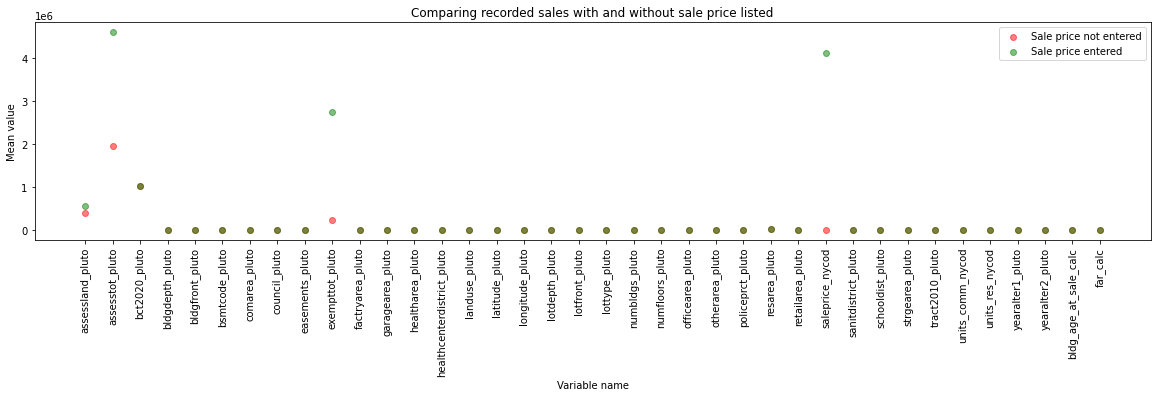

In [92]:
#assess zeros
zeros1 = df[df['saleprice_nycod'] == 0]
nonzeros1 = df[df['saleprice_nycod'] != 0]

zeros = pd.DataFrame(pd.DataFrame(zeros1.describe().T)['mean'])
nonzeros = pd.DataFrame(pd.DataFrame(nonzeros1.describe().T)['mean'])

print("Observations with sale price 0: {}".format(len(zeros1)))
print("Observations with sale price > 0: {}".format(len(nonzeros1)))
print("Missing sale price: {:.3f}%".format(100*len(zeros1)/(len(zeros1)+len(nonzeros1))))

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
plt.scatter(zeros.index, zeros['mean'], label='Sale price not entered', alpha=0.5, color='red')
plt.scatter(nonzeros.index, nonzeros['mean'], label='Sale price entered', alpha=0.5, color='green')
plt.xticks(rotation=90)
plt.xlabel('Variable name')
plt.ylabel('Mean value')
plt.legend()
plt.title("Comparing recorded sales with and without sale price listed")
plt.savefig('missing data.png')
plt.show()

In [93]:
#drop rows where sale price is 0 or 1
df = df[df['saleprice_nycod'] != 0]
df = df[df['saleprice_nycod'] != 1]
len(df)

19261

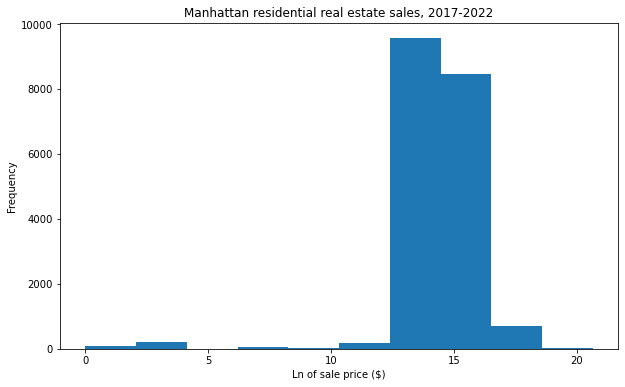

In [94]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(np.log(nonzeros1['saleprice_nycod']))
plt.xlabel('Ln of sale price ($)')
plt.ylabel('Frequency')
plt.title('Manhattan residential real estate sales, 2017-2022')
plt.savefig('hist.png')
plt.show()

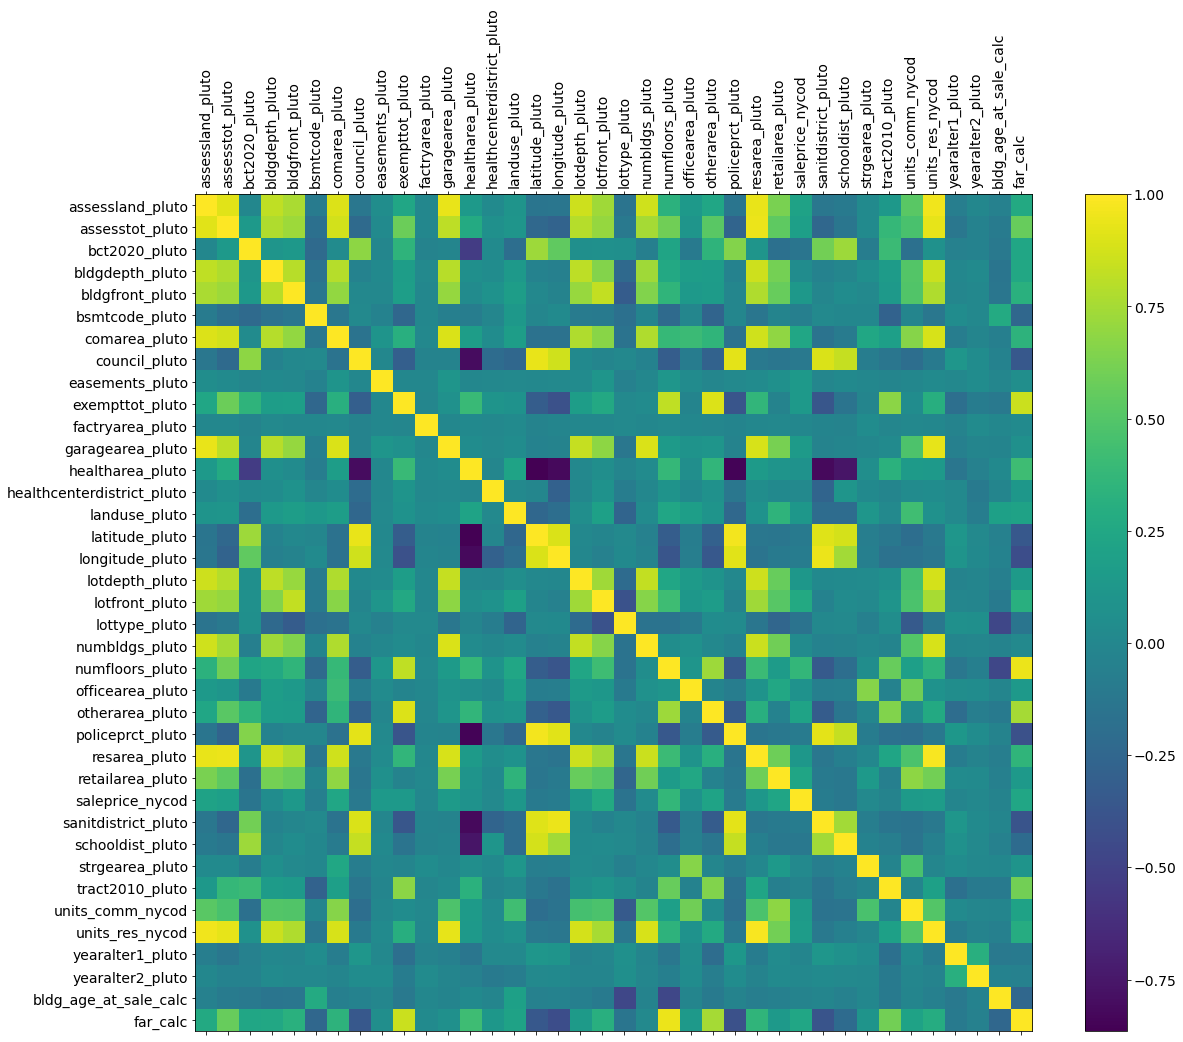

In [95]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.savefig('corrmatrix.png')
plt.show()

# Run models

### Train test split

In [96]:
#sort values by date
from datetime import datetime
dates = []
for i in df['saledate_nycod']:
    a = datetime.strptime(i, '%Y-%m-%d')
    dates.append(a)
df['saledate_calc'] = dates
df = df.sort_values('saledate_calc')

In [97]:
df = df.drop(columns=['saledate_nycod', 'saledate_calc'])

#subset into X and y
X = df.drop('saleprice_nycod', axis=1)
y = np.log(df['saleprice_nycod'])

#split into train test split
train_size = round(len(df)*0.75)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [113]:
df.describe().T.to_csv('describe_T.csv')

In [98]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14446, 37)
(14446,)
(4815, 37)
(4815,)


## Create preprocessor for full model

In [99]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features_full = X_train.select_dtypes([np.number]).columns.tolist()

categorical_features_full = X_train.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_full),
        ('cat', categorical_transformer, categorical_features_full)])

preprocess_full=preprocessor_full.fit(X_train) 

def preprocessor_full(data):
    preprocessed_data=preprocess_full.transform(data)
    return preprocessed_data

## Random Forest

### RF on all features

In [60]:
## Random Forest for feat. selection

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'max_depth': [10, 20, 30, 40, 50],
              'n_estimators': [10, 20, 30, 40, 50]}

grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv=10)

grid.fit(preprocessor_full(X_train), y_train)

print("best median cross-val score: {}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {}".format(grid.score(preprocessor_full(X_test), y_test)))

best median cross-val score: 0.027403077289546007
best parameters: {'max_depth': 10, 'n_estimators': 40}
test-set score: 0.13683888352718288


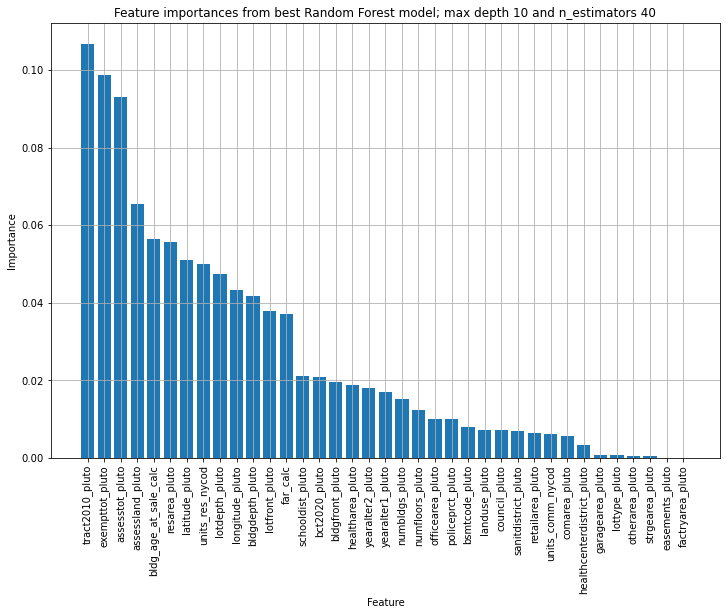

In [100]:
best_forest = RandomForestRegressor(max_depth = grid.best_params_['max_depth'], n_estimators=grid.best_params_['n_estimators']).fit(preprocessor_full(X_train), y_train)

forest_1_predictions = best_forest.predict(preprocessor_full(X_test))

feature_names = X_train.columns
forest_importances = pd.DataFrame(best_forest.feature_importances_, index=feature_names).sort_values([0], ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(forest_importances.index, forest_importances[0])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature importances from best Random Forest model; max depth {} and n_estimators {}'.format(
    grid.best_params_['max_depth'], grid.best_params_['n_estimators']))
plt.grid()
plt.savefig('featureimportances.png')
plt.show()

In [101]:
most_imp_cols = forest_importances.index[:20]

X_train_imp = X_train[most_imp_cols]
X_test_imp = X_test[most_imp_cols]

### Create preprocessor for subsetted features

In [102]:
numeric_features_sub = X_train_imp.select_dtypes([np.number]).columns.tolist()

categorical_features_sub = X_train_imp.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_sub = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_sub),
        ('cat', categorical_transformer, categorical_features_sub)])

preprocess_sub=preprocessor_sub.fit(X_train_imp) 

def preprocessor_sub(data):
    preprocessed_data=preprocess_sub.transform(data)
    return preprocessed_data

### RF on subset of features

In [103]:
rf = RandomForestRegressor(n_estimators=20, max_depth=20).fit(preprocessor_sub(X_train_imp), y_train)
#param_grid = {'max_depth': [10, 15, 20, 25],
              #'n_estimators': [10, 30, 50, 100]}
#grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv=10)

print("Train set score: {:.5f}".format(rf.score(preprocessor_sub(X_train_imp), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(rf, preprocessor_sub(X_train_imp), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(rf.score(preprocessor_sub(X_test_imp), y_test)))

forest_2_predictions = rf.predict(preprocessor_sub(X_test_imp))

Train set score: 0.26043
Mean cross-val score for train set: 0.01592
Test set score: 0.11999.


### OLS on all features

Train set score: 0.03413
Mean cross-val score for train set: -1709805254233022791680.00000
Test set score: -0.31490.


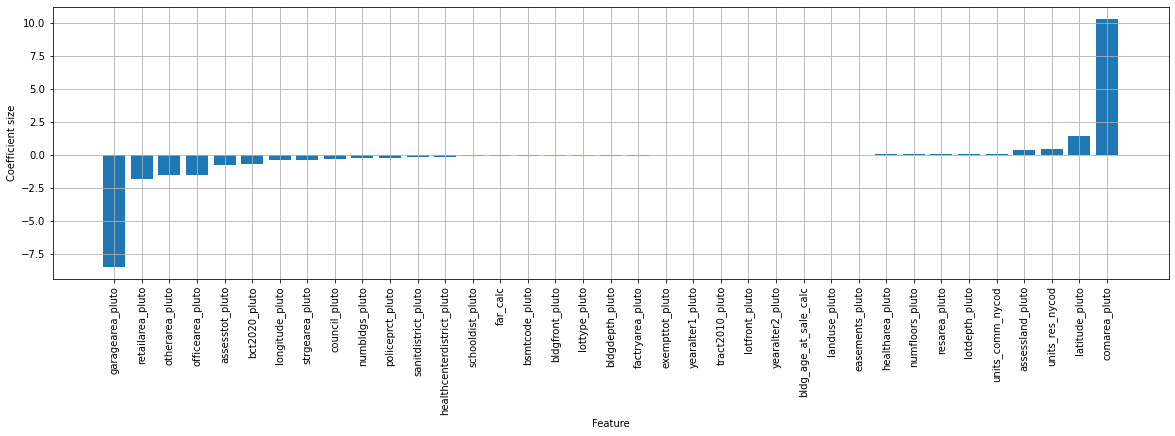

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(preprocessor_full(X_train), y_train)

print("Train set score: {:.5f}".format(lr.score(preprocessor_full(X_train), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(lr, preprocessor_full(X_train), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(lr.score(preprocessor_full(X_test), y_test)))

ols_1_predictions = lr.predict(preprocessor_full(X_test))

#sort results by coefficient size
ols_1_results = pd.concat((pd.DataFrame(X_train.columns), pd.DataFrame(lr.coef_)), axis=1)
ols_1_results.columns = ['column', 'coef']
ols_1_results = ols_1_results.sort_values('coef', ascending=True)

#plot figure
plt.figure(figsize=(20, 5))
plt.bar(ols_1_results.column, ols_1_results.coef)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Feature")
plt.ylabel('Coefficient size')
plt.savefig("fullolscoefs.png")
plt.show()

### OLS on subset of features

Train set score: 0.02331
Mean cross-val score for train set: -0.03110
Test set score: -0.38906.


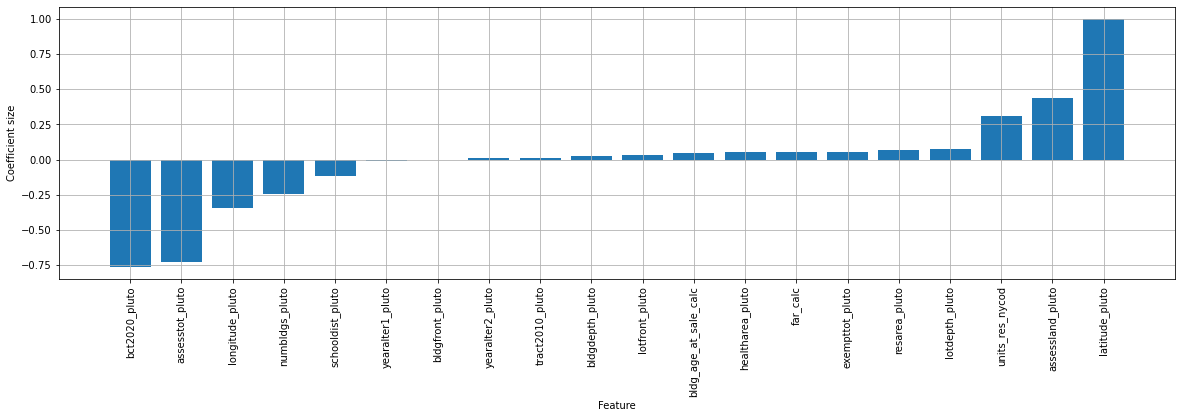

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(preprocessor_sub(X_train_imp), y_train)

print("Train set score: {:.5f}".format(lr.score(preprocessor_sub(X_train_imp), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(lr, preprocessor_sub(X_train_imp), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(lr.score(preprocessor_sub(X_test_imp), y_test)))

ols_2_predictions = lr.predict(preprocessor_sub(X_test_imp))

#sort results by coefficient size
ols_2_results = pd.concat((pd.DataFrame(X_train_imp.columns), pd.DataFrame(lr.coef_)), axis=1)
ols_2_results.columns = ['column', 'coef']
ols_2_results = ols_2_results.sort_values('coef', ascending=True)

#plot figure
plt.figure(figsize=(20, 5))
plt.bar(ols_2_results.column, ols_2_results.coef)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Feature")
plt.ylabel('Coefficient size')
plt.savefig("subsetcoefs.png")
plt.show()

## Model comparison

In [106]:
results = pd.DataFrame()
results['Model'] = ['RF, all features', 'RF, 20 features', 'OLS, all features', 'OLS, 20 features']
results = results.set_index('Model')

from sklearn.metrics import mean_squared_error
import math

#RMSE AND %RMSE
results['RMSE'] = [math.sqrt(mean_squared_error(forest_1_predictions, y_test)), 
                  math.sqrt(mean_squared_error(forest_2_predictions, y_test)), 
                  math.sqrt(mean_squared_error(ols_1_predictions, y_test)), 
                  math.sqrt(mean_squared_error(ols_2_predictions, y_test))]

def percent_rmse(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return rmspe
results['%RMSE'] = [percent_rmse(y_test, forest_1_predictions),
                   percent_rmse(y_test, forest_2_predictions),
                   percent_rmse(y_test, ols_1_predictions),
                   percent_rmse(y_test, ols_2_predictions)]

#MAE AND MAPE
from sklearn.metrics import mean_absolute_error
results['MAE'] = [mean_absolute_error(y_test, forest_1_predictions).round(2), 
                  mean_absolute_error(y_test, forest_2_predictions), 
                  mean_absolute_error(y_test, ols_1_predictions), 
                  mean_absolute_error(y_test, ols_2_predictions)]

def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

results['%MAE'] = [MAPE(y_test, forest_1_predictions),
                   MAPE(y_test, forest_2_predictions),
                   MAPE(y_test, ols_1_predictions),
                   MAPE(y_test, ols_2_predictions)]

#R2 (COEFFICIENT OF DETERMINATION)
from sklearn.metrics import r2_score
results['R-squared'] = [r2_score(y_test, forest_1_predictions), 
                  r2_score(y_test, forest_2_predictions), 
                  r2_score(y_test, ols_1_predictions), 
                  r2_score(y_test, ols_2_predictions)]

results = results.round(3)
results

,RMSE,%RMSE,MAE,%MAE,R-squared
Model,,,,,
"RF, all features",1.359,0.387,0.820,8.035,0.105
"RF, 20 features",1.348,0.370,0.822,7.925,0.120
"OLS, all features",1.647,0.449,0.955,9.349,-0.315
"OLS, 20 features",1.693,0.456,0.967,9.474,-0.389


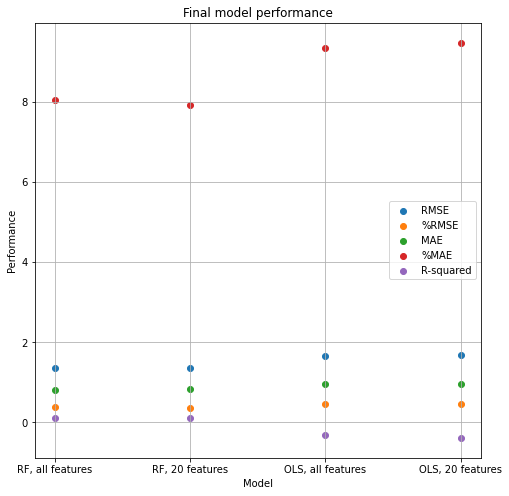

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for i in results.columns:
    plt.scatter(results.index, results[i], label=i)
plt.legend()
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('Final model performance')
plt.savefig('model_performance.png')
plt.grid()
plt.show()

In [108]:
#hit rates
y_test_for_hit_rate = list(y_test)
hit_rates = pd.DataFrame(index=['RF, all features', 'RF, 20 features', 'OLS, all features', 'OLS, 20 features'], 
                         columns=['Within 1%', 'Within 5%', 'Within 10%'])
predictions = [forest_1_predictions, forest_2_predictions, ols_1_predictions, ols_2_predictions]
def predict_hit_rate(y_true, y_pred, margin):
    a = 0
    rate_tmp = []
    for i in y_pred:
        if i >= y_true.iloc[a]*(1-margin):
            if i >= y_true.iloc[a]*(1+margin):
                rate_tmp.append(1)
            else:
                pass
        else:
            rate_tmp.append(0)
        a += 1
    return(sum(rate_tmp) / len(rate_tmp))

hit_rates['Within 1%']['RF, all features'] = predict_hit_rate(y_test, forest_1_predictions, 0.01)*100
hit_rates['Within 1%']['RF, 20 features'] = predict_hit_rate(y_test, forest_2_predictions, 0.01)*100
hit_rates['Within 1%']['OLS, all features'] = predict_hit_rate(y_test, ols_1_predictions, 0.01)*100
hit_rates['Within 1%']['OLS, 20 features'] = predict_hit_rate(y_test, ols_2_predictions, 0.01)*100
hit_rates['Within 5%']['RF, all features'] = predict_hit_rate(y_test, forest_1_predictions, 0.05)*100
hit_rates['Within 5%']['RF, 20 features'] = predict_hit_rate(y_test, forest_2_predictions, 0.05)*100
hit_rates['Within 5%']['OLS, all features'] = predict_hit_rate(y_test, ols_1_predictions, 0.05)*100
hit_rates['Within 5%']['OLS, 20 features'] = predict_hit_rate(y_test, ols_2_predictions, 0.05)*100
hit_rates['Within 10%']['RF, all features'] = predict_hit_rate(y_test, forest_1_predictions, 0.10)*100
hit_rates['Within 10%']['RF, 20 features'] = predict_hit_rate(y_test, forest_2_predictions, 0.10)*100
hit_rates['Within 10%']['OLS, all features'] = predict_hit_rate(y_test, ols_1_predictions, 0.10)*100
hit_rates['Within 10%']['OLS, 20 features'] = predict_hit_rate(y_test, ols_2_predictions, 0.10)*100

hit_rates.astype(float).round(3)

,Within 1%,Within 5%,Within 10%
"RF, all features",45.914,43.514,29.962
"RF, 20 features",46.465,43.937,31.171
"OLS, all features",44.037,40.170,28.746
"OLS, 20 features",43.750,40.571,29.358


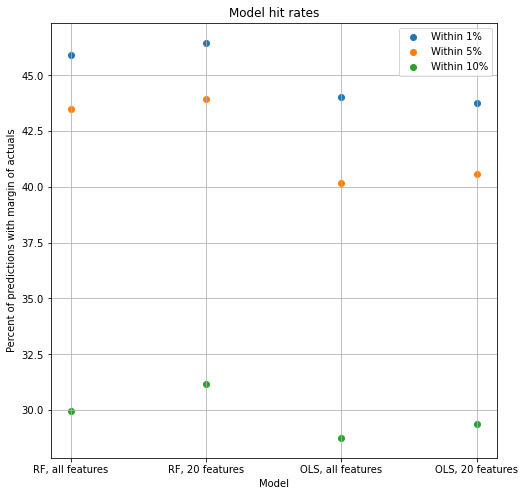

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in hit_rates.columns:
    plt.scatter(hit_rates.index, hit_rates[i], label=i)
plt.legend()
plt.xlabel('Model')
plt.ylabel('Percent of predictions with margin of actuals')
plt.title('Model hit rates')
plt.savefig('hit_rates.png')
plt.grid()
plt.show()

# Archives

In [ ]:
#join census data
census = pd.read_csv('Data/nyc_decennialcensusdata_2010_2020_change.csv', header=3)
census = census[census['Borough']=='Manhattan']
census.head()
new = df.merge(census, how='left', left_on=['bct2020_pluto'], right_on=['BCT2020'])
new.head()